<a href="https://colab.research.google.com/github/ufbfung/fire/blob/main/fire_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your current age: 36
Enter your retirement age: 40
Enter your current savings: 679000
Enter your monthly contribution to taxable accounts: 3600
Enter your annual employer match in numbers (not percent): 11500
Enter your annual expenses: 59000
Enter the interest rate you want to use for investments: 7
Do you want to set the max for 401k, IRA, and HSA? (yes/no): yes


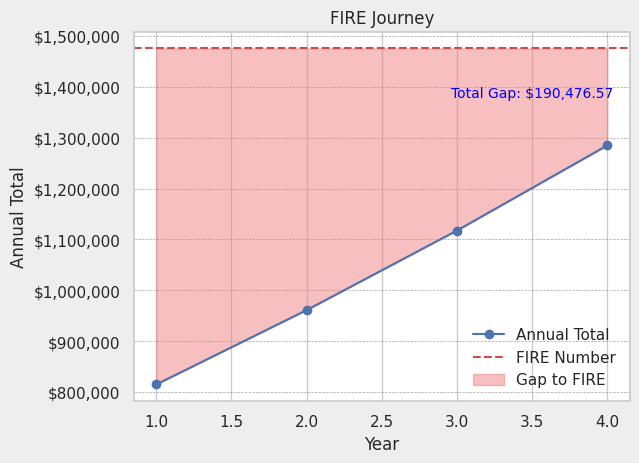


FIRE Projection:
Year     Savings        401K        IRA        HSA Monthly Cash  Annual Total
   1 $726,530.00  $34,500.00  $7,000.00  $4,150.00   $43,200.00   $815,381.00
   2 $777,387.10  $71,415.00 $14,490.00  $8,590.50   $89,424.00   $961,308.60
   3 $831,804.20 $110,914.05 $22,504.30 $13,341.84  $138,883.68 $1,117,451.06
   4 $890,030.49 $153,178.03 $31,079.60 $18,425.76  $191,805.54 $1,284,523.43

Additional Savings Needed:
  Total Gap     Annual   Monthly
$190,476.57 $47,619.14 $3,968.26


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def calculate_fire_number(annual_expenses):
    return annual_expenses * 25

def calc_future_principal(principal, interest_rate, years):
    interest_rate_decimal = interest_rate / 100

    # Initialize lists to store data
    years_list = list(range(1, years + 1))
    future_principal_list = []

    # Loop through each year
    for year in years_list:
        # Calculate the future value of principal for the current year
        future_principal = principal * (1 + interest_rate_decimal) ** year

        # Append the value to the list
        future_principal_list.append(future_principal)

    # Create a DataFrame
    future_principal_df = pd.DataFrame({
        'Year': years_list,
        'Savings': future_principal_list
    })

    return future_principal_df

def calc_future_value_contributions_annual(annual_contribution, interest_rate, years, contrib_source):
    interest_rate_decimal = interest_rate / 100

    # Initialize lists to store data
    years_list = list(range(1, years + 1))
    future_values_list = []

    # Loop through each year
    for year in years_list:
        # Calculate the future value of principal for the current year
        future_value = annual_contribution * ((1 + interest_rate_decimal) ** year - 1) / interest_rate_decimal

        # Append the value to the list
        future_values_list.append(future_value)

    # Create a DataFrame with a dynamic column name based on contrib_source
    future_values_df = pd.DataFrame({
        'Year': years_list,
        f'{contrib_source}': future_values_list
    })

    return future_values_df

def calc_tax_advantaged_accounts(employer_match, interest_rate, years):
    # If the user wants to set the max for all three accounts
    set_max = input("Do you want to set the max for 401k, IRA, and HSA? (yes/no): ").lower() == "yes"

    if set_max:
        max_401k = 23000
        max_ira = 7000
        max_hsa = 4150
    else:
        max_401k = float(input("Enter the max 401k contribution: "))
        max_ira = float(input("Enter the max IRA contribution: "))
        max_hsa = float(input("Enter the max HSA contribution: "))

    # Calculate the total future value across all three accounts
    total_401k_df = calc_future_value_contributions_annual(max_401k + employer_match, interest_rate, years, contrib_source = "401K")
    total_ira_df = calc_future_value_contributions_annual(max_ira, interest_rate, years, contrib_source = "IRA")
    total_hsa_df = calc_future_value_contributions_annual(max_hsa, interest_rate, years, contrib_source = "HSA")

    return total_401k_df, total_ira_df, total_hsa_df

def calc_future_value_contributions_monthly(monthly_contribution, interest_rate, years):
    interest_rate_decimal = interest_rate / 100

    # Initialize lists to store data
    years_list = list(range(1, years + 1))
    future_values_list = []

    # Convert monthly contribution to annual since we assume annual compounding
    annual_contribution = monthly_contribution * 12

    # Loop through each year
    for year in years_list:
        # Calculate the future value
        future_value = annual_contribution * ((1 + interest_rate_decimal) ** year - 1) / interest_rate_decimal

        # Append the value to the list
        future_values_list.append(future_value)

    # Create a DataFrame
    future_values_df = pd.DataFrame({
        'Year': years_list,
        'Monthly Cash': future_values_list
    })

    return future_values_df

def create_final_df(future_savings_df, total_401k_df, total_ira_df, total_hsa_df, future_monthly_contributions_df):
    # Merge DataFrames on 'Year' column
    final_df = pd.merge(future_savings_df, total_401k_df, on='Year', how='outer')
    final_df = pd.merge(final_df, total_ira_df, on='Year', how='outer')
    final_df = pd.merge(final_df, total_hsa_df, on='Year', how='outer')
    final_df = pd.merge(final_df, future_monthly_contributions_df, on='Year', how='outer')

    # Fill NaN values with 0
    final_df = final_df.fillna(0)

    # Calculate the annual total by summing all columns
    final_df['Annual Total'] = final_df.sum(axis=1)

    return final_df

def plot_fire_journey(final_df, fire_number, saving_years):
    # Create a formatter for y-axis ticks in money format
    money_format = '${x:,.0f}'
    formatter = ticker.StrMethodFormatter(money_format)

    # Set a whimsical style using seaborn
    sns.set_theme(style='whitegrid')

    # Plot the annual total
    plt.plot(final_df['Year'], final_df['Annual Total'], label='Annual Total', marker='o')

    # Add a horizontal line for the fire number
    plt.axhline(y=fire_number, color='r', linestyle='--', label='FIRE Number')

    # Shade the region between the annual total and the fire number
    plt.fill_between(final_df['Year'], final_df['Annual Total'], fire_number, where=(final_df['Annual Total'] < fire_number), color='lightcoral', alpha=0.5, label='Gap to FIRE')

    # Calculate and display the exact amount of the gap in the last year
    last_year = final_df['Year'].max()
    last_year_gap = fire_number - final_df.loc[final_df['Year'] == last_year, 'Annual Total'].values[0]

    # Calculate the middle year of the shaded region
    middle_year = final_df['Year'].max() - 0.5

    # Display total gap in the middle of the shaded region
    plt.text(middle_year, fire_number - last_year_gap / 2, f'Total Gap: ${last_year_gap:,.2f}', color='blue', fontsize=10, ha='center')

    # Set labels and title
    plt.xlabel('Year')
    plt.ylabel('Annual Total')
    plt.title('FIRE Journey')

    # Add money format to y-axis ticks
    plt.gca().get_yaxis().set_major_formatter(formatter)

    # Add legend
    plt.legend()

    # Add whimsical decorations
    plt.gcf().set_facecolor('#eeeeee')  # Set background color
    plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.5, color='gray')  # Add dashed grid lines

    # Show the plot
    plt.show()

    # return last year gap
    return last_year_gap

def main():
    # Gather user inputs
    current_age = int(input("Enter your current age: "))
    retirement_age = int(input("Enter your retirement age: "))
    saving_years = retirement_age - current_age
    current_savings = int(input("Enter your current savings: "))
    monthly_contribution = int(input("Enter your monthly contribution to taxable accounts: "))
    employer_match = int(input("Enter your annual employer match in numbers (not percent): "))
    annual_expenses = int(input("Enter your annual expenses: "))
    interest_rate = int(input("Enter the interest rate you want to use for investments: "))

    # Calculate the fire stats
    fire_number = calculate_fire_number(annual_expenses)
    current_gap = fire_number - current_savings

    # Calculate the future value of current savings, tax-advantaged accounts, and monthly contributions
    future_savings_df = calc_future_principal(current_savings, interest_rate, saving_years)
    df_401k, df_ira, df_hsa = calc_tax_advantaged_accounts(employer_match, interest_rate, saving_years)
    future_monthly_contributions_df = calc_future_value_contributions_monthly(monthly_contribution, interest_rate, saving_years)

    # Calculate the final DataFrame
    final_df = create_final_df(future_savings_df, df_401k, df_ira, df_hsa, future_monthly_contributions_df)

    # Plot FIRE Journey
    last_year_gap = plot_fire_journey(final_df, fire_number, saving_years)

    # Display Calculations
    print("\nFIRE Projection:")
    print(final_df.to_string(index=False, formatters={'Year': '{:.0f}'.format, **{col: '${:,.2f}'.format for col in final_df.columns if col != 'Year'}}))

    # Calculate remaining gap and additional savings needed
    additional_annual_savings_needed = last_year_gap / saving_years
    additional_monthly_savings_needed = additional_annual_savings_needed / 12

    # Create a DataFrame to display additional savings needed
    additional_savings_df = pd.DataFrame({
        'Total Gap': [last_year_gap],
        'Annual': [additional_annual_savings_needed],
        'Monthly': [additional_monthly_savings_needed]
    })

    # Display additional savings needed
    print("\nAdditional Savings Needed:")
    print(additional_savings_df.to_string(index=False, formatters={'Total Gap': '${:,.2f}'.format, 'Annual': '${:,.2f}'.format, 'Monthly': '${:,.2f}'.format}))

if __name__ == "__main__":
    main()